# SQL Queries with Differential Privacy

<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/opendp/smartnoise-sdk/blob/main/sql/samples/SQL%20Queries.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/opendp/smartnoise-sdk/blob/main/sql/samples/SQL%20Queries.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://www.kaggle.com/notebooks/welcome?src=https://github.com/opendp/smartnoise-sdk/blob/main/sql/samples/SQL%20Queries.ipynb">
      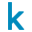
      Run on Kaggle
    </a>
  </td>                                                                                               
</table>

In [ ]:
!pip install smartnoise-sql --quiet

## Read data
Smartnoise supports issue SQL queries against CSV files, database engines, and Spark clusters.

In [ ]:
import pandas as pd

pums = pd.read_csv("https://raw.githubusercontent.com/opendifferentialprivacy/dp-test-datasets/master/data/PUMS_california_demographics_1000/data.csv")

print(pums)

## Execute DP query

Open a private SQL connection

In [ ]:
from snsql import *

# Adopted from https://github.com/opendp/smartnoise-sdk/blob/main/datasets/PUMS.yaml
metadata = {
  "PUMS": {
    "PUMS": {
      "PUMS": {
        "row_privacy": True,
        "rows": 1000,
        "age": {
          "type": "int",
          "lower": 0,
          "upper": 100
        },
        "sex": {
          "type": "string"
        },
        "educ": {
          "type": "string"
        },
        "race": {
          "type": "string"
        },
        "income": {
          "type": "int",
          "lower": 0,
          "upper": 500000
        },
        "married": {
          "type": "string"
        }
      }
    }
  }
}

private_reader = from_connection(
    pums, metadata=metadata, 
    privacy=Privacy(epsilon=1.0, delta=1/1000)
)

query = 'SELECT married, COUNT(*) AS n FROM PUMS.PUMS GROUP BY married'

result_dp = private_reader.execute_df(query)
print(result_dp)

**Note**, in the above example, we query the PUMS microdata to get the count of individuals by marriage status.  If you run the private query repeatedly, you will see that the answer changes a bit between queries.

In [ ]:
result_dp = private_reader.execute_df(query)
print(result_dp)

The `PrivateReader` allows you to swap in differentially private results wherever exact results are currently used, it can accept some additional paramaters to control privacy/accuracy tradeoff.  Smaller epsilon will be more private, but less accurate. 

In [ ]:
for epsilon in [4.0, 0.1]:
    private_reader = from_connection(
        pums, metadata=metadata, 
        privacy=Privacy(epsilon=epsilon, delta=1/1000)
    )
    print(f"epsilon is: {epsilon}")
    result = private_reader.execute_df(query)
    print(result)
    print()

## Execute normal query 
Calling the underlying `Reader` directly will give the exact result.

In [ ]:
result = private_reader.reader.execute_df(query)

print(result)

## Metadata file

The `PrivateReader` needs some metadata that describes the data source.  Differentially private processing needs to know which columns can be used in numeric computations, as well as information about the sensitivity of data, and which column is the private identifier.  Metadata should be provided by the data owner, and should not be data-dependent.  For example, the acceptable range for the `age` column should be domain-specific, and should not use the actual minimum and maximum values from the data:

In [ ]:
import snsql
from pathlib import Path
metadata_path = Path("./PUMS.yaml")
metadata_string = """PUMS:
  PUMS:
    PUMS:
      row_privacy: True
      rows: 1000
      age:
        type: int
        lower: 0
        upper: 100
      sex:
        type: string
      educ:
        type: string
      race:
        type: string
      income:
        type: int
        lower: 0
        upper: 500000
      married:
        type: string
"""
with open(metadata_path, "w+") as f:
    f.write(metadata_string)
    
meta = snsql.metadata.Metadata.from_file(metadata_path)
print(meta)

Metadata can be also supply as a dictionary.

In [ ]:
metadata = {
  "PUMS": {
    "PUMS": {
      "PUMS": {
        "row_privacy": True,
        "rows": 1000,
        "age": {
          "type": "int",
          "lower": 0,
          "upper": 100
        },
        "sex": {
          "type": "string"
        },
        "educ": {
          "type": "string"
        },
        "race": {
          "type": "string"
        },
        "income": {
          "type": "int",
          "lower": 0,
          "upper": 500000
        },
        "married": {
          "type": "string"
        }
      }
    }
  }
}

meta = snsql.metadata.Metadata.from_dict(metadata)
print(meta)